# Committor Estimate on the Muller-Brown Potential

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyedgar
from pyedgar.data_manipulation import tlist_to_flat, flat_to_tlist

%matplotlib inline

## Load Data and set Hyperparameters
We first load in the pre-sampled data.  The data consists of 1000 short trajectories, each with 5 datapoints.  The precise sampling procedure is described in "Galerkin Approximation of Dynamical Quantities using Trajectory Data" by Thiede et al.  Note that this is a smaller dataset than in the paper.  We use a smallar dataset to ensure the diffusion map basis construction runs in a reasonably short time.

### Set Hyperparameters
Here we specify a few hyperparameters.  Thes can be varied to study the behavior of the scheme in various limits by the user.

In [2]:
ntraj = 1000
trajectory_length = 5
dim = 10

### Load and format the data

In [3]:
trajs = np.load('data/muller_brown_trajs.npy')[:ntraj, :trajectory_length, :dim] # Raw trajectory
stateA = np.load('data/muller_brown_stateA.npy')[:ntraj, :trajectory_length] # 1 if in state A, 0 otherwise
stateB = np.load('data/muller_brown_stateB.npy')[:ntraj, :trajectory_length] # 1 if in state B, 0 otherwise

print("Data shape: ", trajs.shape)

# Convert to list of trajectories format
trajs = [traj_i for traj_i in trajs]
stateA = [A_i for A_i in stateA]
stateB = [B_i for B_i in stateB]

Data shape:  (1000, 5, 10)


We also convert the data into the flattened format.  This converts the data into a 2D array, which allows the data to be passed into many ML packages that require a two-dimensional dataset.  In particular, this is the format accepted by the Diffusion Atlas object.  Trajectory start/stop points are then stored in the traj_edges array.

In [4]:
flattened_trajs, traj_edges = tlist_to_flat(trajs)
flattened_stateA = np.hstack(stateA)
flattened_stateB = np.hstack(stateB)
print("Flattened Shapes are: ", flattened_trajs.shape, flattened_stateA.shape, flattened_stateB.shape,)

Flattened Shapes are:  (5000, 10) (5000,) (5000,)


Finally, we load the reference, "true" committor for comparison.

In [5]:
ref_comm = np.load('reference/reference_committor.npy')
ref_potential = np.load('reference/potential.npy')
xgrid = np.load('reference/xgrid.npy')
ygrid = np.load('reference/ygrid.npy')

Text(0.5,1,'True Committor')

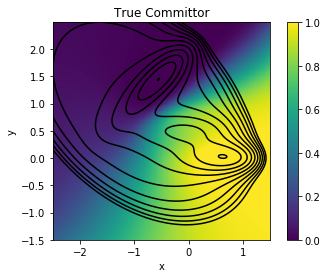

In [6]:
 # Plot the true committor.
fig, ax = plt.subplots(1)
HM = ax.pcolor(xgrid, ygrid, ref_comm, vmin=0, vmax=1)
ax.contour(xgrid, ygrid, ref_potential, levels=np.linspace(0, 10., 11), colors='k') # Contour lines every 1 k_B T
ax.set_aspect('equal')
cbar = plt.colorbar(HM, ax=ax)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('True Committor')

## Construct DGA Committor
We now use PyEDGAR to build an estimate for the forward committor.

### Build Basis Set
We first build the basis set required for the DGA Calculation.  In this demo, we will use the diffusion map basis.  

In [7]:
diff_atlas = pyedgar.basis.DiffusionAtlas.from_sklearn(alpha=0, k=500, bandwidth_type='-1/d', epsilon='bgh_generous')
diff_atlas.fit(flattened_trajs)

Here, we construct the basis and guess functions, and convert them back into lists of trajectories. The domain is the set of all sets out side of $(A\cup B)^c$.

In [8]:
flat_basis, evals = diff_atlas.make_dirichlet_basis(300, in_domain=(1. - flattened_stateA - flattened_stateB), return_evals=True)
flat_guess = diff_atlas.make_FK_soln(flattened_stateB, in_domain=(1. - flattened_stateA - flattened_stateB))

basis = flat_to_tlist(flat_basis, traj_edges)
guess = flat_to_tlist(flat_guess, traj_edges)

We plot the guess function and the first few basis functions.

Text(0.5,0,'x')

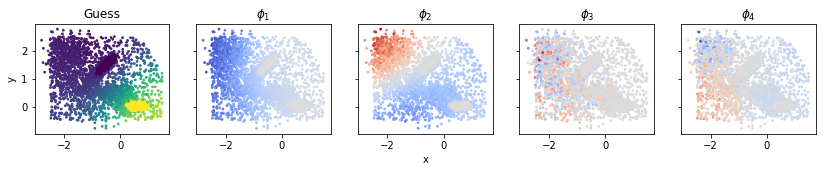

In [9]:
fig, axes= plt.subplots(1, 5, figsize=(14,4.), sharex=True, sharey=True)
axes[0].scatter(flattened_trajs[:,0], flattened_trajs[:,1], 
                c=flat_guess, s=3)
axes[0].set_title('Guess')
axes[0].set_ylabel("y")

for i, ax in enumerate(axes[1:]):
    vm = np.max(np.abs(flat_basis[:, i]))
    ax.scatter(flattened_trajs[:,0], flattened_trajs[:,1], 
               c=flat_basis[:, i], s=3, cmap='coolwarm', 
               vmin=-1*vm, vmax=vm)
    ax.set_title(r"$\phi_%d$" % (i+1))

for ax in axes:
    ax.set_aspect('equal')
#     ax.
axes[2].set_xlabel("x")

The third basis function looks like noise from the perspective of the $x$ and $y$ coordinates.  This is because it correlates  most strongly with the harmonic degrees of freedom.  Note that due to the boundary conditions, it is not precisely the dominant eigenvector of the harmonic degrees of freedom.

Text(0,0.5,'$z_4$')

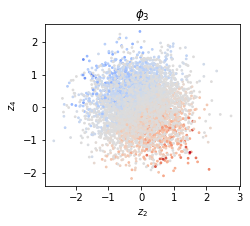

In [10]:
fig, (ax1) = plt.subplots(1, figsize=(3.5,3.5))

vm = np.max(np.abs(flat_basis[:,2]))
ax1.scatter(flattened_trajs[:,3], flattened_trajs[:,5], 
            c=flat_basis[:, 2], s=3, cmap='coolwarm', 
            vmin=-1*vm, vmax=vm)

ax1.set_aspect('equal')
ax1.set_title(r"$\phi_%d$" % 3)
ax1.set_xlabel("$z_2$")
ax1.set_ylabel("$z_4$")

### Build the committor function

We are ready to compute the committor function using DGA.  This can be done by passing the guess function and the basis to the the Galerkin module.

In [11]:
g = pyedgar.galerkin.compute_committor(basis, guess, lag=1)

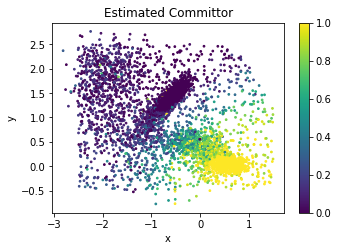

In [12]:
fig, (ax1) = plt.subplots(1, figsize=(5.5,3.5))

SC = ax1.scatter(flattened_trajs[:,0], flattened_trajs[:,1], c=np.array(g).ravel(), vmin=0., vmax=1., s=3)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Estimated Committor')
plt.colorbar(SC)
ax1.set_aspect('equal')

Here, we plot how much the DGA estimate perturbs the Guess function

Text(0.5,1,'Estimate - Guess')

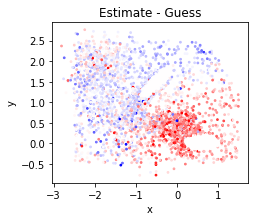

In [13]:
fig, (ax1) = plt.subplots(1, figsize=(3.5,3.5))

ax1.scatter(flattened_trajs[:,0], flattened_trajs[:,1], c=np.array(g).ravel() - flat_guess, 
            vmin=-.5, vmax=.5, cmap='bwr', s=3)
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Estimate - Guess')

## Compare against reference

To compare against the reference values, we will interpolate the reference onto the datapoints usingy scipy's interpolate package.

In [14]:
import scipy.interpolate as spi

spline = spi.RectBivariateSpline(xgrid, ygrid, ref_comm.T)
ref_comm_on_data = np.array([spline.ev(c[0], c[1]) for c in flattened_trajs[:,:2]])
ref_comm_on_data[ref_comm_on_data < 0.] = 0.
ref_comm_on_data[ref_comm_on_data > 1.] = 1.

A comparison of our estimate with the True committor.  While the estimate is good, we systematically underestimate the committor near (0, 0.5).

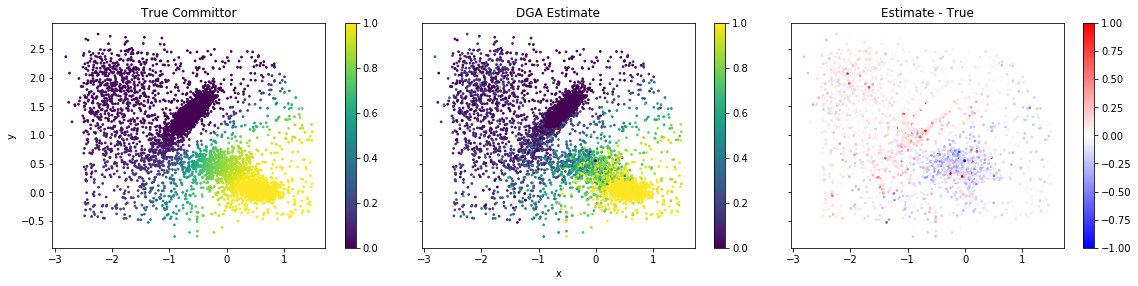

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16,3.5), sharex=True, sharey=True)
(ax1, ax2, ax3) = axes
SC = ax1.scatter(flattened_trajs[:,0], flattened_trajs[:,1], c=ref_comm_on_data, vmin=0., vmax=1., s=3)
plt.colorbar(SC, ax=ax1)
SC = ax2.scatter(flattened_trajs[:,0], flattened_trajs[:,1], c=np.array(g).ravel(), vmin=0., vmax=1., s=3)
plt.colorbar(SC, ax=ax2)
SC = ax3.scatter(flattened_trajs[:,0], flattened_trajs[:,1], c=np.array(g).ravel() -ref_comm_on_data, 
                 vmin=-1, vmax=1, s=3, cmap='bwr')
plt.colorbar(SC, ax=ax3)


# ax1.set_aspect('equal')
ax2.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('True Committor')
ax2.set_title('DGA Estimate')
ax3.set_title('Estimate - True')
plt.tight_layout(pad=-1.)
for ax in axes:
    ax.set_aspect('equal')